### Outline

The purpose of this notebook is to calculate zone entry and exit-related data for tracked games, and generate TOI and shot-related data for the same games.

Here's what we'll do:
- Download NZ data (not included)
- Aggregate NZ data 
- Augment with PBP/TOI data as needed
- Calculate metrics at team, individual, line, and pair levels, for and against. For example:
    - Entries per 60
    - Failed entries per 60
    - Controlled entries per 60
    - Failed entries per 60
    - Controlled entry%
    - Failed entry%
    - Shots per entry
    - Controlled exits per 60

In [1]:
from os import listdir, chdir, getcwd
import pandas as pd
from pylab import *
from tqdm import tqdm # progress bar
%matplotlib inline
current_wd = getcwd()

### Aggregate NZ data

They're in a bunch of separate .xlsx files. We just aggregate them together.

Each excel file has three sheets we want:

- Shot Data
- Raw Entries
- Zone Exits Raw Data

First, let's copy everything to csv, which will make for faster file read-in later on.

In [2]:
# Want to combine all files
folders = ['/Users/muneebalam/Downloads/Game Reports 1718/', 
           #'/Users/muneebalam/Downloads/Passing Game Archive 1718/',
           '/Users/muneebalam/Downloads/Game Reports 1617/']
sheets = {'shots': 'Shot Data', 'entries': 'Raw Entries', 'exits': 'Zone Exits Raw Data'}

copy = False

if copy:
    for folder in folders:
        chdir(folder)
        files = listdir()
        files = [f for f in files if f[-5:] == '.xlsx']
        for file in tqdm(files, desc='Converting to csv'):
            xl = pd.ExcelFile(file)
            sheetnames = xl.sheet_names
            for s in sheetnames:
                df = xl.parse(s)
                fout = '{0:s}_{1:s}.csv'.format(file[:-5], s)
                df.to_csv(fout, index=False)
        print('Done with', folder)

Now, let's check--do the sheets we're interested in (listed in cell above) contain the same columns?

In [3]:
colnames = {}
for skey, sval in sheets.items():
    colnames[sval] = {}
    for folder in folders:
        chdir(folder)
        files = listdir()
        files = [f for f in files if f[f.rfind('_')+1:-4] == sval]
        for file in tqdm(files, desc='Reading files'):
            try:
                cnames = pd.read_csv(file).columns
            except Exception as e:
                print(skey, sval, file, e, e.args)
                continue
                
            cnames = tuple(sorted(cnames))
            if cnames not in colnames[sval]:
                colnames[sval][cnames] = set()
            colnames[sval][cnames].add('{0:s}-{1:s}'.format(folder[-5:-1], file[:5]))  # Season and game number
        print('Done with', skey, folder)

Reading files:   6%|▌         | 18/301 [00:00<00:01, 171.62it/s]

Done with shots /Users/muneebalam/Downloads/Game Reports 1718/


Reading files:   8%|▊         | 17/220 [00:00<00:01, 167.05it/s]

Done with shots /Users/muneebalam/Downloads/Game Reports 1617/


Reading files:   7%|▋         | 20/301 [00:00<00:01, 197.02it/s]

Done with entries /Users/muneebalam/Downloads/Game Reports 1718/


Reading files:  13%|█▎        | 29/220 [00:00<00:00, 279.97it/s]

Done with entries /Users/muneebalam/Downloads/Game Reports 1617/


Reading files:   9%|▉         | 27/301 [00:00<00:01, 267.12it/s]

exits Zone Exits Raw Data 20330 Dallas at Colorado_Zone Exits Raw Data.csv No columns to parse from file ('No columns to parse from file',)
Done with exits /Users/muneebalam/Downloads/Game Reports 1718/


Reading files: 100%|██████████| 301/301 [00:01<00:00, 251.42it/s]

Done with exits /Users/muneebalam/Downloads/Game Reports 1617/


In [4]:
def intersect(*sets):
    if len(sets) == 0:
        return set()
    if len(sets) == 1:
        return sets[0]
    if len(sets) == 2:
        return set(sets[0]) & set(sets[1])
    return set(sets[0]) & intersect(*tuple(sets[1:]))
        
for sval in colnames:
    # Figure out column name frequency
    colcount = {}
    for clist in colnames[sval].keys():
        for c in clist:
            if c not in colcount:
                colcount[c] = 0
            colcount[c] += len(colnames[sval][clist])
    colcount = [(k, v) for k, v in colcount.items()]
    colcount = sorted(colcount, key = lambda x: x[1], reverse=True)
    print(sval)
    for k, v in colcount:
        # Only ones with more than 200, for brevity's sake
        if v >= 200:
            print(k, v)
    print('')

Shot Data
A1 517
A2 517
A3 517
Away Goalies 517
Away:  517
Date 517
Game ID 517
Goalie 517
Home Goalies 517
Home: 517
SOG? 517
Strength 517
Team 517
Time 517
PBP Time 516
Period 516
Unnamed: 28 513
Unnamed: 29 478
Screen 462
A1 Zone 297
A2 Zone 297
A3 Zone 297
G? 297
Oddman 297
RB/2C 297
RB/2C SOG? 297
SC? 297
Shot Type? 297
RB/2C G? 296
Home Score State 295
Shooter 295
Player 221
Chance? 220
Goal? 220
Goal?.1 220
Oddman? 220
P1 Z 220
P2 Z 220
P3 Z 220
Rebound? 220
SOG 220
State 220
Type 220

Raw Entries
Controlled? 516
Defended by 516
Dump recovered? 516
Entry by 516
Entry type 516
Fail 516
Fen total 516
Game 516
Goal total 516
Goalie touch? 516
Location 516
Middle driver 516
Opp 516
Opp strength 516
Team strength 516
Time 516
Period 515

Zone Exits Raw Data
Attempt 515
Direction 515
Entry? 515
Pass Target 515
Period 515
Pressured? 515
Result 515
Time 515



They look like they're in decent shape--there's a lot of overlap. I'll keep items with at least 515 occurrences.

In [5]:
cols_to_keep = {}
for sval in colnames:
    # Figure out column name frequency
    colcount = {}
    for clist in colnames[sval].keys():
        for c in clist:
            if c not in colcount:
                colcount[c] = 0
            colcount[c] += len(colnames[sval][clist])
    cols_to_keep[sval] = [k for k, v in colcount.items() if v >= 515]
print(cols_to_keep)

{'Shot Data': ['A1', 'A2', 'A3', 'Away Goalies', 'Away: ', 'Date', 'Game ID', 'Goalie', 'Home Goalies', 'Home:', 'PBP Time', 'Period', 'SOG?', 'Strength', 'Team', 'Time'], 'Raw Entries': ['Controlled?', 'Defended by', 'Dump recovered?', 'Entry by', 'Entry type', 'Fail', 'Fen total', 'Game', 'Goal total', 'Goalie touch?', 'Location', 'Middle driver', 'Opp', 'Opp strength', 'Period', 'Team strength', 'Time'], 'Zone Exits Raw Data': ['Attempt', 'Direction', 'Entry?', 'Pass Target', 'Period', 'Pressured?', 'Result', 'Time']}


So now, we'll combine.

In [6]:
dfs = {k: [] for k in sheets.keys()}

generate = False

for skey, sval in sheets.items():
    fout = skey + ' combined.csv'
    
    if generate:
        for folder in folders:
            chdir(folder)
            files = listdir()
            files = [f for f in files if f[f.rfind('_')+1:-4] == sval]
            for file in tqdm(files, desc='Reading files'):
                try:
                    df = pd.read_csv(file)

                    # Exclude columns I don't want
                    cols = set(df.columns) - set(cols_to_keep[sval])
                    df = df.drop(cols, axis=1, errors='ignore')
                    df = df.assign(Season=2000 + int(folder[-5:-3]), Game=int(file[:5]))
                    dfs[skey].append(df)
                except Exception as e:
                    print(skey, sval, file, e, e.args)
                    continue

            print('Done with', skey, folder)
        dfs[skey] = pd.concat(dfs[skey])
        dfs[skey].to_csv(fout, index=False)
    dfs[skey] = pd.read_csv(fout)
chdir(current_wd)
print('Done aggregating and reading files')

/Users/muneebalam/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Done aggregating and reading files


/Users/muneebalam/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/muneebalam/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Here's what the dataframes look like:

In [7]:
dfs['shots'].head()

,A1,A2,A3,Away Goalies,Away:,Date,Game,Game ID,Goalie,Home Goalies,Home:,PBP Time,Period,SOG?,Season,Strength,Team,Time
0,16NYI,13NYI,NYI,35.0,PHI,2017-01-15,20279,20279,33.0,31,WSH,00:53:00,1.0,NaN,2017,5v5,NYI,19:23:00
1,NYI,NYI,NYI,30.0,PHI,2017-01-15,20279,20279,33.0,70,WSH,02:10:00,1.0,NaN,2017,5v5,NYI,19:16:00
2,CAR,CAR,CAR,NaN,PHI,2017-01-15,20279,20279,1.0,NaN,WSH,02:15:00,1.0,NaN,2017,5v5,CAR,18:31:00
3,66NYI,72NYI,NYI,NaN,PHI,2017-01-15,20279,20279,33.0,NaN,WSH,02:17:00,1.0,NaN,2017,5v5,NYI,18:21:00
4,25NYI,66NYI,NYI,NaN,PHI,2017-01-15,20279,20279,33.0,NaN,WSH,02:18:00,1.0,NaN,2017,5v5,NYI,17:51:00


In [8]:
dfs['entries'].head()

,Controlled?,Defended by,Dump recovered?,Entry by,Entry type,Fail,Fen total,Game,Goal total,Goalie touch?,Location,Middle driver,Opp,Opp strength,Period,Season,Team strength,Time
0,55WPG,N,N,55WPG,C,NaN,0.0,20193,0.0,R,Home,N,DAL,5.0,1.0,2017,5,19:45:00
1,NaN,44WPG,N,3DAL,F,3DAL,0.0,20193,0.0,R,Home,NaN,DAL,5.0,1.0,2017,5,19:33:00
2,NaN,N,N,13WPG,D,NaN,0.0,20193,0.0,R,Home,NaN,DAL,5.0,1.0,2017,5,19:12:00
3,NaN,N,N,12DAL,D,NaN,0.0,20193,0.0,R,Home,NaN,DAL,5.0,1.0,2017,5,19:02:00
4,NaN,N,16WPG,9WPG,D,NaN,1.0,20193,0.0,R,Home,NaN,DAL,5.0,1.0,2017,5,18:56:00


In [9]:
dfs['exits'].head()

,Period,Time,Attempt,Result,Pressured?,Pass Target,Entry?,Direction,Game,Season
0,1,19:19:00,25EDM,P,N,93EDM,Y,L,20198,2017
1,1,18:33:00,63NJ,M,N,N,N,R,20198,2017
2,1,18:25:00,14NJ,M,N,11NJ,N,L,20198,2017
3,1,18:05:00,25NJ,P,N,11NJ,Y,L,20198,2017
4,1,18:00:00,55EDM,C,N,N,Y,C,20198,2017


### Augment with PBP/TOI

Let's look at how complete the shot data is. I'll take a 10% sample of Caps games and compare shot counts in the tracked data with the PBP.

First, the games selected:

In [10]:
np.random.seed(8)  # Obv, for shots, pick Ovechkin
wsh_games = dfs['shots'].query('Team == "WSH"')[['Season', 'Game']].drop_duplicates().sort_values(['Season', 'Game'])
wsh_games.loc[:, 'RandomNum'] = np.random.randint(low=0, high=100, size=len(wsh_games))
wsh_games.loc[:, 'Selected'] = wsh_games.RandomNum.apply(lambda x: x <= 10)
wsh_games = wsh_games.query('Selected == True').drop('RandomNum', axis=1)
wsh_games.set_index(['Season', 'Game'])  # Just for viewing purposes

Selected
Season Game           
2016   20022      True
       20071      True
       20860      True
2017   20047      True
       20555      True

Here are the shot counts from the tracked data:

In [11]:
wsh_shots = dfs['shots'].merge(wsh_games[['Season', 'Game']], how='inner', on=['Season', 'Game']) \
    .query('Strength == "5v5"')
wsh_shots.loc[:, 'Team'] = wsh_shots.Team.apply(lambda x: x if x == 'WSH' else 'Opp')
wsh_shots = wsh_shots[['Season', 'Game', 'Team']].assign(Count=1) \
    .groupby(['Season', 'Game', 'Team'], as_index=False) \
    .count()
wsh_shots = wsh_shots.pivot_table(index=['Season', 'Game'], columns='Team', values='Count')
wsh_shots

Team          Opp  WSH
Season Game           
2016   20022   37   39
       20071   39   45
       20860   47   39
2017   20047   43   46
       20555   35   47

Now, let's pull shot counts for those games from our scraped data.

In [12]:
from scrapenhl2.scrape import teams
df1 = teams.get_team_pbp(2016, 'WSH').assign(Season=2016)
df2 = teams.get_team_pbp(2017, 'WSH').assign(Season=2017)
df3 = pd.concat([df1, df2]).merge(wsh_games[['Season', 'Game']], how='inner', on=['Season', 'Game'])

# Go to 5v5 only
from scrapenhl2.manipulate import manipulate as manip
df3 = manip.filter_for_five_on_five(manip.filter_for_corsi(df3))

counts = df3[['Season', 'Game', 'Team']]
counts.loc[:, 'Team'] = counts.Team.apply(lambda x: 'WSH' if x == 15 else 'Opp')

counts = counts.assign(Count=1) \
    .groupby(['Season', 'Game', 'Team'], as_index=False) \
    .count()
counts = counts.pivot_table(index=['Season', 'Game'], columns='Team', values='Count')
counts

/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Team          Opp  WSH
Season Game           
2016   20022   40   42
       20071   40   43
       20860   43   31
2017   20047   43   44
       20555   42   52

The counts are pretty close, so we'll use the tracked data.

We still need TOI, though. I'll pull a second-by-second log into a dataframe.

In [13]:
from scrapenhl2.scrape import players, team_info

dfs['toi'] = {}

team_convert = {'LA': 'LAK', 'NJ': 'NJD', 'TB': 'TBL', 'SJ': 'SJS', 
                'L.A': 'LAK', 'N.J': 'NJD', 'T.B': 'TBL', 'S.J': 'SJS'}
for team in dfs['shots'].Team.unique():
    if team in team_convert:
        team = team_convert[team]
    if not isinstance(team, str) or len(team) != 3:
        #print('Skipping', team)
        continue
            
    toi = []
    for season in range(2016, 2018):
        try:
            toi.append(teams.get_team_toi(season, team).assign(Season=season))
        except Exception as e:
            print('Could not read', team, e, e.args)
            
    toi = pd.concat(toi)
    
    # Filter for appropriate games using an inner join, and filter for 5v5
    toi = toi.merge(dfs['shots'][['Season', 'Game']].drop_duplicates(), 
                    how='inner', on=['Season', 'Game']) 
    toi = manip.filter_for_five_on_five(toi)
    
    # Get only certain columns
    toi = toi[['Season', 'Game', 'Time', 'Team1', 'Team2', 'Team3', 'Team4', 'Team5']]
    renaming = {'Team{0:d}'.format(i): '{0:s}{1:d}'.format(team, i) for i in range(1, 6)}
    toi = toi.rename(columns=renaming)
    
    # Convert to player names
    for col in toi.columns[3:]:
        toi.loc[:, col] = toi[col].apply(lambda x: players.player_as_str(x))
    dfs['toi'][team] = toi

dfs['toi']['WSH'].head()

Could not read VGK IOError: Failed to open file: /Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/data/teams/toi/2016/VGK.feather ('IOError: Failed to open file: /Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/data/teams/toi/2016/VGK.feather',)


,Season,Game,Time,WSH1,WSH2,WSH3,WSH4,WSH5
0,2016,20007,1,Matt Niskanen,Karl Alzner,Evgeny Kuznetsov,Alex Ovechkin,T.J. Oshie
1,2016,20007,2,Matt Niskanen,Karl Alzner,Evgeny Kuznetsov,Alex Ovechkin,T.J. Oshie
2,2016,20007,3,Matt Niskanen,Karl Alzner,Evgeny Kuznetsov,Alex Ovechkin,T.J. Oshie
3,2016,20007,4,Matt Niskanen,Karl Alzner,Evgeny Kuznetsov,Alex Ovechkin,T.J. Oshie
4,2016,20007,5,Matt Niskanen,Karl Alzner,Evgeny Kuznetsov,Alex Ovechkin,T.J. Oshie


One final item: let's filter the entries, exits, and shots dataframes to 5v5 using this TOI data.

In [14]:
fives = {}

from scrapenhl2.manipulate import add_onice_players as onice
dfs['shots'].loc[:, 'Time2'] = dfs['shots'].Time.str.extract(r'(\d{1,2}:\d{1,2}):\d{1,2}$')
dfs['shots'] = onice.add_times_to_file(dfs['shots'].dropna(subset=['Time']),
                                       periodcol='Period', timecol='Time2', time_format='remaining')
fives['shots'] = dfs['shots']
for team, toi in dfs['toi'].items():
    toi = toi.rename(columns={'Time': '_Secs'})
    fives['shots'] = fives['shots'].merge(toi, how='left', on=['Season', 'Game', '_Secs'])

fives['shots'].head()

/Users/muneebalam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,A1,A2,A3,Away Goalies,Away:,Date,Game,Game ID,Goalie,Home Goalies,...,VGK1,VGK2,VGK3,VGK4,VGK5,VAN1,VAN2,VAN3,VAN4,VAN5
0,16NYI,13NYI,NYI,35.0,PHI,2017-01-15,20279,20279,33.0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NYI,NYI,NYI,30.0,PHI,2017-01-15,20279,20279,33.0,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAR,CAR,CAR,NaN,PHI,2017-01-15,20279,20279,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66NYI,72NYI,NYI,NaN,PHI,2017-01-15,20279,20279,33.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25NYI,66NYI,NYI,NaN,PHI,2017-01-15,20279,20279,33.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
dfs['entries'].loc[:, 'Time2'] = dfs['entries'].Time.str.extract(r'(\d{1,2}:\d{1,2}):\d{1,2}$')
dfs['entries'] = onice.add_times_to_file(dfs['entries'].dropna(subset=['Time']),
                                         periodcol='Period', timecol='Time2', time_format='remaining')

fives['entries'] = dfs['entries']
for team, toi in dfs['toi'].items():
    toi = toi.rename(columns={'Time': '_Secs'})
    fives['entries'] = fives['entries'].merge(toi, how='left', on=['Season', 'Game', '_Secs'])

fives['entries'].head()

/Users/muneebalam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,Controlled?,Defended by,Dump recovered?,Entry by,Entry type,Fail,Fen total,Game,Goal total,Goalie touch?,...,VGK1,VGK2,VGK3,VGK4,VGK5,VAN1,VAN2,VAN3,VAN4,VAN5
0,55WPG,N,N,55WPG,C,NaN,0.0,20193,0.0,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,44WPG,N,3DAL,F,3DAL,0.0,20193,0.0,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,N,N,13WPG,D,NaN,0.0,20193,0.0,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,N,N,12DAL,D,NaN,0.0,20193,0.0,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,N,16WPG,9WPG,D,NaN,1.0,20193,0.0,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dfs['exits'].loc[:, 'Time2'] = dfs['exits'].Time.str.extract(r'(\d{1,2}:\d{1,2}):\d{1,2}$')
dfs['exits'] = onice.add_times_to_file(dfs['exits'].dropna(subset=['Time']),
                                       periodcol='Period', timecol='Time2', time_format='remaining')

fives['exits'] = dfs['exits']
for team, toi in dfs['toi'].items():
    toi = toi.rename(columns={'Time': '_Secs'})
    fives['exits'] = fives['exits'].merge(toi, how='left', on=['Season', 'Game', '_Secs'])

fives['exits'].head()

/Users/muneebalam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,Period,Time,Attempt,Result,Pressured?,Pass Target,Entry?,Direction,Game,Season,...,VGK1,VGK2,VGK3,VGK4,VGK5,VAN1,VAN2,VAN3,VAN4,VAN5
0,1,19:19:00,25EDM,P,N,93EDM,Y,L,20198,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,18:33:00,63NJ,M,N,N,N,R,20198,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,18:25:00,14NJ,M,N,11NJ,N,L,20198,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,18:05:00,25NJ,P,N,11NJ,Y,L,20198,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,18:00:00,55EDM,C,N,N,Y,C,20198,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's look at games included by team.

In [17]:
teamcolnames = [x for x in fives['shots'].columns if x == x.upper() and len(x) == 4 and x[-1] == '1']
gps = []
for teamcol in teamcolnames:
    gp = len(dfs['toi'][teamcol[:-1]][['Season', 'Game']].drop_duplicates())
    print(teamcol[:3], gp)
    gps.append(gp)
print('Total', sum(gps))

NYI 46
CAR 28
BOS 28
LAK 25
MIN 32
MTL 36
NYR 52
TOR 35
PIT 37
EDM 34
ANA 29
CBJ 43
FLA 28
NJD 30
STL 25
TBL 39
COL 29
SJS 27
ARI 21
PHI 99
DET 27
NSH 29
WPG 28
CHI 23
WSH 34
CGY 39
OTT 27
BUF 25
DAL 28
VGK 12
VAN 21
Total 1016


Let's reduce this to just Caps games now.

In [18]:
wsh = {key: fives[key].dropna(subset=['WSH1']) for key in ['shots', 'entries', 'exits']}
wsh['shots'].head()

,A1,A2,A3,Away Goalies,Away:,Date,Game,Game ID,Goalie,Home Goalies,...,VGK1,VGK2,VGK3,VGK4,VGK5,VAN1,VAN2,VAN3,VAN4,VAN5
4143,51TOR,TOR,TOR,35.0,PHI,2017-01-15,20084,20084,70.0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4144,TOR,TOR,TOR,30.0,PHI,2017-01-15,20084,20084,70.0,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4145,34TOR,TOR,TOR,NaN,PHI,2017-01-15,20084,20084,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4146,19WSH,77WSH,74WSH,NaN,PHI,2017-01-15,20084,20084,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4147,12TOR,43TOR,TOR,NaN,PHI,2017-01-15,20084,20084,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's convert numbers to names. I don't have a lookup table handy, so I'll do it by hand.

In [19]:
wsh['shots'][['WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']] \
    .melt(var_name='P', value_name='Name') \
    ['Name'].value_counts()

Dmitry Orlov           1532
John Carlson           1450
Matt Niskanen          1344
Alex Ovechkin          1294
Brooks Orpik           1293
Evgeny Kuznetsov       1214
Nicklas Backstrom      1181
T.J. Oshie             1084
Lars Eller             1023
Karl Alzner             957
Brett Connolly          865
Jay Beagle              839
Andre Burakovsky        798
Tom Wilson              775
Marcus Johansson        685
Justin Williams         656
Nate Schmidt            585
Jakub Vrana             522
Daniel Winnik           430
Christian Djoos         376
Madison Bowey           323
Devante Smith-Pelly     307
Alex Chiasson           257
Zach Sanford            217
Chandler Stephenson     184
Taylor Chorney          174
Aaron Ness              152
Kevin Shattenkirk       106
Nathan Walker            59
Tyler Graovac            38
Name: Name, dtype: int64

In [20]:
wsh_players = {'Alex Ovechkin': 8, 'Nicklas Backstrom': 19, 'Andre Burakovsky': 65,
              'T.J. Oshie': 77, 'John Carlson': 74, 'Evgeny Kuznetsov': 92,
              'Dmitry Orlov': 9, 'Christian Djoos': 29, 'Devante Smith-Pelly': 25,
              'Jay Beagle': 83, 'Brooks Orpik': 44, 'Chandler Stephenson': 18,
              'Jakub Vrana': 13, 'Tom Wilson': 43, 'Lars Eller': 20,
              'Alex Chiasson': 39, 'Brett Connolly': 10, 'Madison Bowey': 22, 'Kevin Shattenkirk': 22,
              'Tyler Graovac': 91, '': 36, 'Matt Niskanen': 2, 
              'Aaron Ness': 55, 'Nathan Walker': 79, 'Taylor Chorney': 4,
              'Zach Sanford': 12, 'Karl Alzner': 27, 'Marcus Johansson': 90, 
               'Zachary Sanford': 12,
               'Justin Williams': 14, 'Daniel Winnik': 26, 'Nate Schmidt': 88}

for col in ['WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']:
    for key in ['shots', 'entries', 'exits']:
        wsh[key].loc[:, col] = wsh[key][col].apply(lambda x: str(wsh_players[x]) + 'WSH' if x in wsh_players else x)
wsh['shots'].head()

/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,A1,A2,A3,Away Goalies,Away:,Date,Game,Game ID,Goalie,Home Goalies,...,VGK1,VGK2,VGK3,VGK4,VGK5,VAN1,VAN2,VAN3,VAN4,VAN5
4143,51TOR,TOR,TOR,35.0,PHI,2017-01-15,20084,20084,70.0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4144,TOR,TOR,TOR,30.0,PHI,2017-01-15,20084,20084,70.0,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4145,34TOR,TOR,TOR,NaN,PHI,2017-01-15,20084,20084,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4146,19WSH,77WSH,74WSH,NaN,PHI,2017-01-15,20084,20084,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4147,12TOR,43TOR,TOR,NaN,PHI,2017-01-15,20084,20084,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Entries per 60

In [21]:
# Team comparison

# Drop extra team cols
allteamcols = [x for x in fives['entries'].columns if not x.upper() == x]
allteams = fives['entries'][allteamcols]

# Remove fails and faceoffs
allteams = allteams[pd.isnull(allteams.Fail)]
allteams = allteams[allteams['Entry type'] != 'FAC']

# Counts by game and team
allteams = allteams[['Season', 'Game', 'Entry by', 'Entry type']]
# Extract ending text part of entry. 
import re
def extract_team(string):
    result = re.search('\d*(\w{2,3})$', str(string))
    if result:
        return result.group(1)
    return string
allteams.loc[:, 'Team'] = allteams['Entry by'].apply(lambda x: extract_team(x))

# Get rid of typo teams -- about 100 in 77000
valid_teams = set(allteams.Team.value_counts().index[:31])
allteams = allteams[allteams.Team.apply(lambda x: x in valid_teams)]

allteams = allteams.drop('Entry by', axis=1) \
    .assign(Count=1) \
    .groupby(['Season', 'Game', 'Team', 'Entry type'], as_index=False) \
    .count()
    
# Add opp numbers
gametotals = allteams.drop('Team', axis=1) \
    .groupby(['Season', 'Game', 'Entry type'], as_index=False) \
    .sum() \
    .rename(columns={'Count': 'OppCount'})

fives['toi'] = pd.concat([dfs['toi'][team] \
                          [['Season', 'Game']] \
                          .assign(TOI=1) \
                          .groupby(['Season', 'Game'], as_index=False) \
                          .count() for team in dfs['toi']]).drop_duplicates()

# Sum by season and calculate per 60
allteams = allteams.merge(fives['toi'], how='left', on=['Season', 'Game'])
allteams = allteams.merge(gametotals, how='inner', on=['Season', 'Game', 'Entry type']) \
    .drop('Game', axis=1) \
    .groupby(['Season', 'Entry type', 'Team'], as_index=False) \
    .sum()
allteams.loc[:, 'OppCount'] = allteams['OppCount'] - allteams['Count']

allteams.loc[:, 'Per60'] = allteams['Count'] / (allteams.TOI / 3600)
allteams.loc[:, 'OppPer60'] = allteams['OppCount'] / (allteams.TOI / 3600)

allteams.head()

,Season,Entry type,Team,Count,TOI,OppCount,Per60,OppPer60
0,2016,C,ANA,607,47929.0,542,45.592439,40.710217
1,2016,C,ARI,483,37469.0,574,46.406363,55.149590
2,2016,C,BOS,665,48305.0,589,49.560087,43.896077
3,2016,C,BUF,560,44498.0,609,45.305407,49.269630
4,2016,C,CAR,830,58917.0,742,50.715413,45.338357


/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


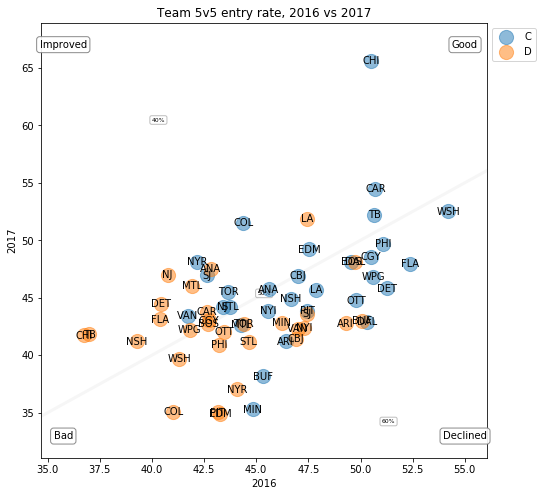

In [22]:
f = figure(figsize=[8, 8])

tmp = allteams[allteams['Entry type'] != 'X'] \
    .drop(['Count', 'OppCount', 'TOI'], axis=1) \
    .pivot_table(index=['Entry type', 'Team'], columns='Season', values='Per60') \
    .reset_index()
    
for etype in tmp['Entry type'].unique():
    tmp2 = tmp[tmp['Entry type'] == etype]
    scatter(tmp2.loc[:, 2016].values, tmp2.loc[:, 2017].values, label=etype, s=200, alpha=0.5)

for s, etype, t, r1, r2 in tmp.itertuples():
    annotate(t, xy=(r1, r2), ha='center', va='center') 

from scrapenhl2.plot import visualization_helper as vhelper
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

title('Team 5v5 entry rate, 2016 vs 2017')
xlabel('2016')
ylabel('2017')
legend(loc=2, bbox_to_anchor=(1, 1))

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


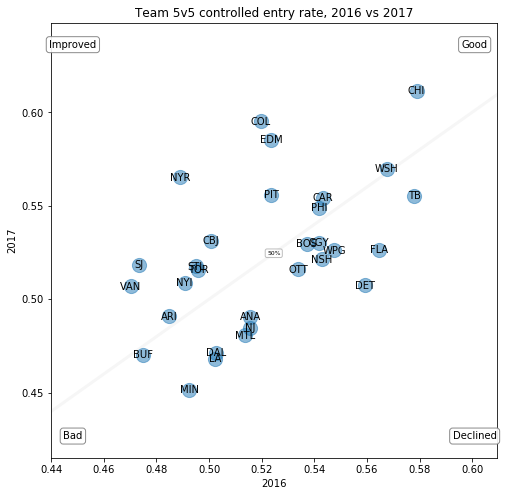

In [23]:
f = figure(figsize=[8, 8])

tmp = allteams[allteams['Entry type'] != 'X'] \
    .drop(['Count', 'OppCount', 'TOI'], axis=1) \
    .pivot_table(index=['Season', 'Team'], columns='Entry type', values='Per60') \
    .reset_index()
    
tmp.loc[:, 'Ctrl%'] = tmp.C / (tmp.C + tmp.D)
tmp = tmp.drop(['C', 'D'], axis=1)
tmp = tmp.pivot_table(index='Team', columns='Season', values='Ctrl%').reset_index()
    
scatter(tmp.loc[:, 2016].values, tmp.loc[:, 2017].values, s=200, alpha=0.5)

for i, t, r1, r2 in tmp.itertuples():
    annotate(t, xy=(r1, r2), ha='center', va='center') 
    
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

title('Team 5v5 controlled entry rate, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


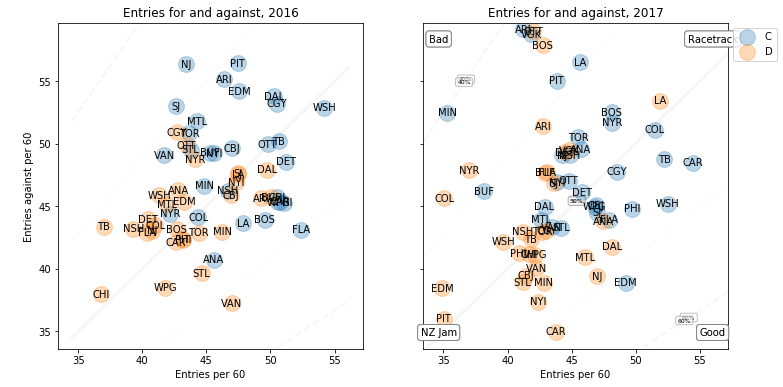

In [24]:
fig, axes = subplots(1, 2, sharex=True, sharey=True, figsize=[12, 6])

for i, season in enumerate(allteams.Season.unique()):
    tmp = allteams[(allteams.Season == season) & (allteams['Entry type'] != 'X')]
    for etype in tmp['Entry type'].unique():
        tmp2 = tmp[tmp['Entry type'] == etype]
        axes[i].scatter(tmp2.Per60.values, tmp2.OppPer60.values, s=250, alpha=0.3, label=etype)
    axes[i].set_title('Entries for and against, {0:d}'.format(season))
    axes[i].set_xlabel('Entries per 60')
    if i == 0:
        axes[i].set_ylabel('Entries against per 60')
    for _, t, r1, r2 in tmp[['Team', 'Per60', 'OppPer60']].itertuples():
        axes[i].annotate(t, xy=(r1, r2), ha='center', va='center')
    vhelper.add_good_bad_fast_slow(bottomleft='NZ Jam', topleft='Bad', topright='Racetrack', bottomright='Good')
    vhelper.add_cfpct_ref_lines_to_plot(ax=axes[i])
    
legend(loc=2, bbox_to_anchor=(1, 1))

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes
/Users/muneebalam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


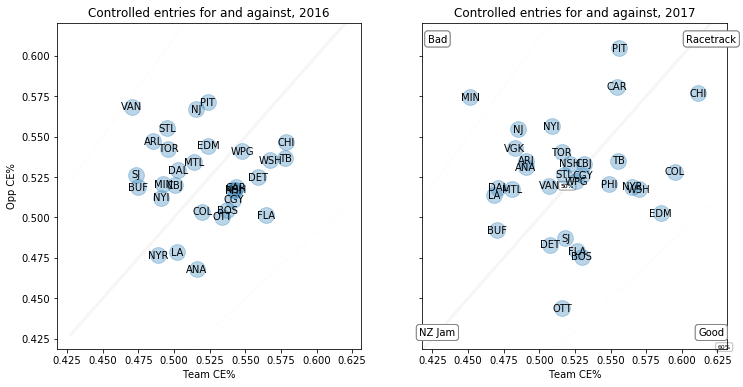

In [25]:
tmp = allteams[allteams['Entry type'] != 'X'] \
    .drop(['Count', 'OppCount', 'TOI'], axis=1) \
    .melt(id_vars=['Season', 'Entry type', 'Team']) \
    .pivot_table(index=['Season', 'Team', 'variable'], columns='Entry type', values='value') \
    .reset_index()

tmp.loc[:, 'CE%'] = tmp.C / (tmp.C + tmp.D)
tmp = tmp.drop(['C', 'D'], axis=1) \
    .pivot_table(index=['Season', 'Team'], columns='variable', values='CE%') \
    .rename(columns={'Per60': 'TeamCE%', 'OppPer60': 'OppCE%'}) \
    .reset_index()
    
fig, axes = subplots(1, 2, sharex=True, sharey=True, figsize=[12, 6])

for i, season in enumerate(tmp.Season.unique()):
    tmp2 = tmp[(tmp.Season == season)]
    axes[i].scatter(tmp2['TeamCE%'].values, tmp2['OppCE%'].values, s=250, alpha=0.3)
    
    axes[i].set_title('Controlled entries for and against, {0:d}'.format(season))
    axes[i].set_xlabel('Team CE%')
    if i == 0:
        axes[i].set_ylabel('Opp CE%')
    for _, t, r1, r2 in tmp2[['Team', 'TeamCE%', 'OppCE%']].itertuples():
        axes[i].annotate(t, xy=(r1, r2), ha='center', va='center')
        
    vhelper.add_good_bad_fast_slow(bottomleft='NZ Jam', topleft='Bad', topright='Racetrack', bottomright='Good')
    vhelper.add_cfpct_ref_lines_to_plot(ax=axes[i])
    
legend(loc=2, bbox_to_anchor=(1, 1))

In [26]:
entries = wsh['entries']

# Drop extra team cols
colnames = [x for x in entries.columns if not x.upper() == x or x[:3] == 'WSH']
entries = entries[colnames]

# Remove fails
entries = entries[pd.isnull(entries.Fail)]

# Flag entries as WSH or Opp
entries.loc[:, 'Team'] = entries['Entry by'].apply(lambda x: 'WSH' if str(x)[-3:] == 'WSH' else 'Opp')

# Remove faceoffs
# entries2 = entries
entries2 = entries[entries['Entry type'] != 'FAC']

# Melt to long
idvars = [x for x in entries2.columns if x not in ['WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']]
entries2 = entries2.melt(id_vars=idvars, value_name='Player').sort_values(['Season', 'Game', '_Secs', 'variable'])

entries2.head()

,Controlled?,Defended by,Dump recovered?,Entry by,Entry type,Fail,Fen total,Game,Goal total,Goalie touch?,...,Opp strength,Period,Season,Team strength,Time,Time2,_Secs,Team,variable,Player
2850,19WSH,3PIT,N,19WSH,C,NaN,0.0,20007,0.0,R,...,5,1.0,2016,5,19:28:00,19:28,33,WSH,WSH1,2WSH
7131,19WSH,3PIT,N,19WSH,C,NaN,0.0,20007,0.0,R,...,5,1.0,2016,5,19:28:00,19:28,33,WSH,WSH2,27WSH
11412,19WSH,3PIT,N,19WSH,C,NaN,0.0,20007,0.0,R,...,5,1.0,2016,5,19:28:00,19:28,33,WSH,WSH3,65WSH
15693,19WSH,3PIT,N,19WSH,C,NaN,0.0,20007,0.0,R,...,5,1.0,2016,5,19:28:00,19:28,33,WSH,WSH4,19WSH
19974,19WSH,3PIT,N,19WSH,C,NaN,0.0,20007,0.0,R,...,5,1.0,2016,5,19:28:00,19:28,33,WSH,WSH5,90WSH


In [27]:
# Season level

# Count by entry type
entries60 = entries2[['Season', 'Entry type', 'Team', 'Game', 'Period', 'Time']] \
    .drop_duplicates() \
    [['Season', 'Entry type', 'Team']] \
    .assign(Count=1) \
    .groupby(['Season', 'Entry type', 'Team'], as_index=False) \
    .count()

# Add TOI
toi = dfs['toi']['WSH'] \
    [['Season']].assign(TOI=1) \
    .groupby('Season', as_index=False).count()

entries60 = entries60.merge(toi, how='left', on='Season')
entries60.loc[:, 'Per60'] = entries60.Count / (entries60.TOI / 3600)

entries60

,Season,Entry type,Team,Count,TOI,Per60
0,2016,C,Opp,601,60976,35.482813
1,2016,C,WSH,686,60976,40.501181
2,2016,D,Opp,609,60976,35.955130
3,2016,D,WSH,611,60976,36.073209
4,2016,X,Opp,36,60976,2.125426
5,2016,X,WSH,48,60976,2.833902
6,2017,C,Opp,361,37848,34.337349
7,2017,C,WSH,429,37848,40.805327
8,2017,D,Opp,385,37848,36.620165
9,2017,D,WSH,376,37848,35.764109


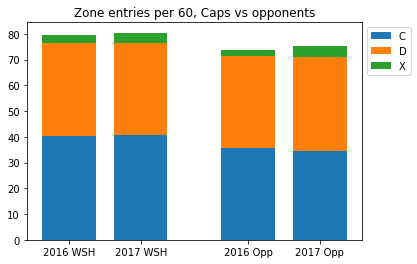

In [28]:
tmp = entries60.assign(Height=entries60.Per60).sort_values(['Season', 'Team', 'Entry type'])
tmp.loc[:, 'Left'] = tmp.Team.apply(lambda x: 0 if x == 'WSH' else 1) + tmp.Season.apply(lambda x: 0 if x == 2016 else 0.4)
tmp.loc[:, 'Bottom'] = tmp.groupby(['Season', 'Team']).Height.cumsum() - tmp.Height
for etype in tmp['Entry type'].unique():
    tmp2 = tmp[tmp['Entry type'] == etype]
    bar(left=tmp2.Left.values, height=tmp2.Height.values, bottom=tmp2.Bottom.values, label=etype, width=0.3)

xlabs = tmp.drop_duplicates(subset=['Season', 'Team', 'Left'])
xticks([x for x in xlabs.Left], ['{0:d} {1:s}'.format(s, t) for s, t in zip(tmp2.Season, tmp2.Team)])
legend(loc=2, bbox_to_anchor=(1, 1))
title('Zone entries per 60, Caps vs opponents')

In [29]:
# Individual level, on-ice

# Count by entry type
entries60 = entries2[['Season', 'Entry type', 'Team', 'Game', 'Period', 'Time', 'Player']] \
    [['Season', 'Entry type', 'Team', 'Player']] \
    .assign(Count=1) \
    .groupby(['Season', 'Entry type', 'Team', 'Player'], as_index=False) \
    .count() \
    .pivot_table(index=['Season', 'Entry type', 'Player'], columns='Team', values='Count') \
    .reset_index()

# Add TOI
toi = dfs['toi']['WSH'] \
    [['Season', 'WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']] \
    .melt(id_vars='Season', value_name='Player') \
    .drop('variable', axis=1) \
    .assign(TOI=1) \
    .groupby(['Season', 'Player'], as_index=False).count()
toi.loc[:, 'Player'] = toi['Player'].apply(lambda x: str(wsh_players[x]) + 'WSH' if x in wsh_players else x)

entries60 = entries60.merge(toi, how='left', on=['Season', 'Player']) \
    .sort_values(['Player', 'Season', 'Entry type'])
entries60.loc[:, 'WSH60'] = entries60.WSH / (entries60.TOI / 3600)
entries60.loc[:, 'Opp60'] = entries60.Opp / (entries60.TOI / 3600)

entries60

,Season,Entry type,Player,Opp,WSH,TOI,WSH60,Opp60
0,2016,C,10WSH,91.0,133.0,10314,46.422339,31.762653
23,2016,D,10WSH,95.0,97.0,10314,33.856894,33.158813
46,2016,X,10WSH,10.0,4.0,10314,1.396161,3.490401
68,2017,C,10WSH,72.0,71.0,6894,37.075718,37.597911
91,2017,D,10WSH,58.0,81.0,6894,42.297650,30.287206
114,2017,X,10WSH,13.0,9.0,6894,4.699739,6.788512
1,2016,C,12WSH,59.0,67.0,5321,45.329825,39.917309
24,2016,D,12WSH,52.0,58.0,5321,39.240744,35.181357
47,2016,X,12WSH,2.0,3.0,5321,2.029694,1.353129
2,2016,C,13WSH,13.0,14.0,1433,35.170970,32.658758


/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'Player' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'Season' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero enco

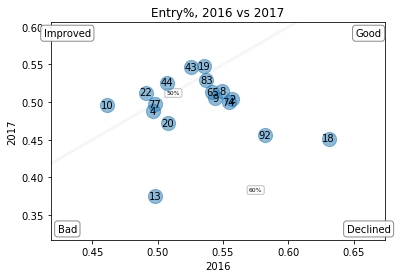

In [30]:
title('Entry%, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

tmp = entries60[['Season', 'Player', 'WSH', 'Opp']] \
    .groupby(['Season', 'Player', 'WSH', 'Opp'], as_index=False) \
    .sum()

tmp.loc[:, 'Entry%'] = tmp.WSH / (tmp.WSH + tmp.Opp)
tmp = tmp.drop(['WSH', 'Opp'], axis=1)
tmp = tmp.pivot_table(index='Player', columns='Season', values='Entry%')

scatter(tmp.loc[:, 2016].values, tmp.loc[:, 2017].values, s=200, alpha=0.5)
for p, e1, e2 in tmp.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center')
    
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


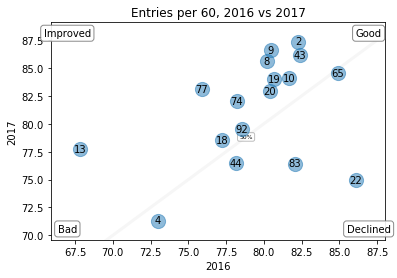

In [31]:
title('Entries per 60, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

tmp = entries60[['Season', 'Player', 'WSH60']] \
    .groupby(['Season', 'Player'], as_index=False) \
    .sum()

tmp = tmp.pivot_table(index='Player', columns='Season', values='WSH60')

scatter(tmp.loc[:, 2016].values, tmp.loc[:, 2017].values, s=200, alpha=0.5)
for p, e1, e2 in tmp.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center')
    
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


(59.225931217350521, 86.247630499935255)

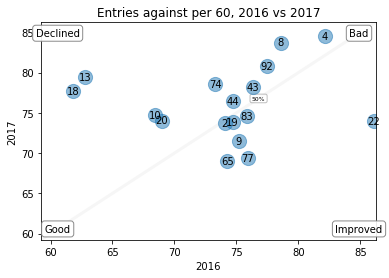

In [32]:
title('Entries against per 60, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

tmp = entries60[['Season', 'Player', 'Opp60']] \
    .groupby(['Season', 'Player'], as_index=False) \
    .sum()

tmp = tmp.pivot_table(index='Player', columns='Season', values='Opp60')

scatter(tmp.loc[:, 2016].values, tmp.loc[:, 2017].values, s=200, alpha=0.5)
for p, e1, e2 in tmp.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center')
    
vhelper.add_good_bad_fast_slow(bottomleft='Good', topleft='Declined', topright='Bad', bottomright='Improved')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

ylim(bottom=xlim()[0])
xlim(right=ylim()[1])

In [33]:
sums = entries60[['Season', 'Player', 'WSH', 'Opp']] \
    .groupby(['Season', 'Player'], as_index=False) \
    .sum()
    
cep = entries60[entries60['Entry type'] == 'C'] \
    [['Season', 'Player', 'WSH', 'Opp']] \
    .merge(sums, how='inner', on=['Season', 'Player'], suffixes=['', '_Tot']) 
    
cep.loc[:, 'CE%'] = cep.WSH / (cep.WSH + cep.WSH_Tot)
cep.loc[:, 'Opp CE%'] = cep.Opp / (cep.Opp + cep.Opp_Tot)

ce = cep[['Season', 'Player', 'CE%']] \
    .pivot_table(index='Player', columns='Season', values='CE%') 
oppce = cep[['Season', 'Player', 'Opp CE%']] \
    .pivot_table(index='Player', columns='Season', values='Opp CE%') 

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


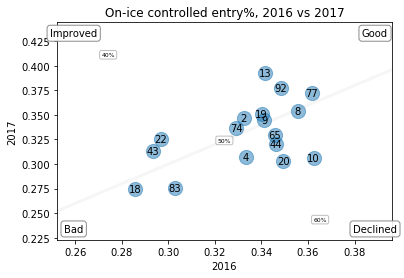

In [34]:
title('On-ice controlled entry%, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

scatter(ce.loc[:, 2016].values, ce.loc[:, 2017].values, s=200, alpha=0.5)
for p, e1, e2 in ce.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center')
    
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:678: RuntimeWarning: invalid value encountered in subtract
  m = (y2 - y1) / (x2 - x1)
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


(0.2, 0.43302679618489265)

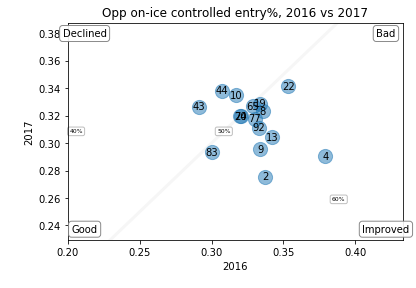

In [35]:
title('Opp on-ice controlled entry%, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

scatter(oppce.loc[:, 2016].values, oppce.loc[:, 2017].values, s=200, alpha=0.5)
for p, e1, e2 in oppce.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center')
    
vhelper.add_good_bad_fast_slow(bottomleft='Good', topleft='Declined', topright='Bad', bottomright='Improved')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])
xlim(left=0.2)

In [36]:
# Individual level, individual

# Count by entry type
ientries60 = entries2[pd.notnull(entries2['Entry by'])]
ientries60 = ientries60[ientries60['Entry by'].str.contains('WSH')] \
    [['Season', 'Entry type', 'Team', 'Game', 'Period', 'Time', 'Entry by', 'Fen total']] \
    .drop_duplicates() \
    [['Season', 'Entry type', 'Team', 'Entry by', 'Fen total']] \
    .assign(Count=1) \
    .groupby(['Season', 'Entry type', 'Team', 'Entry by'], as_index=False) \
    .count() \
    .pivot_table(index=['Season', 'Entry type', 'Entry by'], columns='Team', values='Count') \
    .reset_index()

# Add TOI
toi = dfs['toi']['WSH'] \
    [['Season', 'WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']] \
    .melt(id_vars='Season', value_name='Entry by') \
    .drop('variable', axis=1) \
    .assign(TOI=1) \
    .groupby(['Season', 'Entry by'], as_index=False).count()
toi.loc[:, 'Entry by'] = toi['Entry by'].apply(lambda x: str(wsh_players[x]) + 'WSH' if x in wsh_players else x)

ientries60 = ientries60.merge(toi, how='left', on=['Season', 'Entry by']) \
    .sort_values(['Entry by', 'Season', 'Entry type'])
ientries60.loc[:, 'WSH60'] = entries60.WSH / (entries60.TOI / 3600)

ientries60.drop(['TOI', 'WSH'], axis=1).pivot_table(index=['Entry by', 'Season'], columns='Entry type', values='WSH60')

Entry type               C          D          X
Entry by Season                                 
10WSH    2016    46.422339  41.671102        NaN
         2017     5.024424  45.316901        NaN
13WSH    2016    45.329825  33.856894        NaN
         2017     2.690949  36.129352        NaN
14WSH    2016    35.170970  39.240744        NaN
18WSH    2016          NaN  27.634334        NaN
         2017     2.482901  36.100533        NaN
19WSH    2016    39.385703  38.651808        NaN
         2017     1.908928  32.501567        NaN
20WSH    2016    30.901288  46.351931        NaN
         2017     2.690583  43.442623        NaN
22WSH    2016    41.588597  36.622794        NaN
         2017     3.063308  46.379706        NaN
25WSH    2016    43.189501        NaN        NaN
         2017     3.620343  32.065217        NaN
26WSH    2016    36.322870  35.315172        NaN
27WSH    2016    34.921715  47.085202        NaN
29WSH    2016          NaN  46.562287        NaN
         2017     4.443429  39.339144        NaN
2WSH     2016    39.478977  38.444593        NaN
         2017     4.062223  36.016623        NaN
39WSH    2017     2.478814  31.587886        NaN
43WSH    2016    40.978286  36.864000        NaN
         2017          NaN  30.949106        NaN
44WSH    2016    34.238736  44.104135        NaN
         2017     2.728191  41.505765        NaN
4WSH     2016          NaN  34.322034        NaN
         2017          NaN  41.637232        NaN
55WSH    2017     2.558506  49.250301        NaN
65WSH    2016    41.377119  36.501901        NaN
         2017     2.150281  33.962264        NaN
74WSH    2016    36.501901  37.285281        NaN
         2017     4.244616  29.073857        NaN
77WSH    2016    44.863590  37.281080        NaN
         2017     1.221913  46.938596        NaN
79WSH    2017     3.752263  17.487856        NaN
82WSH    2016    38.377583  30.749014        NaN
83WSH    2016    43.005615  42.163182        NaN
         2017     3.618304  48.181083        NaN
88WSH    2016    35.654771  33.724798        NaN
8WSH     2016    46.188310  32.190466   1.396161
         2017     3.926070  45.545723        NaN
90WSH    2016    44.237204  36.183044        NaN
91WSH    2017     3.193188  42.297650        NaN
92WSH    2016    38.524299  32.648376        NaN
         2017    37.075718  26.824608        NaN
93WSH    2017    50.210164        NaN        NaN
9WSH     2016    41.946964  35.604045        NaN
         2017    29.726869  45.733644        NaN
WSH      2016          NaN        NaN   2.029694
         2017          NaN        NaN  34.542254

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:679: RuntimeWarning: invalid value encountered in subtract
  b = y1 - m*x1
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


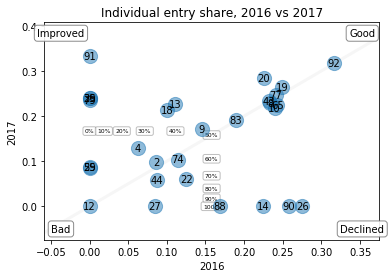

In [37]:
tmp = entries60[['Season', 'Entry type', 'Player', 'WSH']] \
    .merge(ientries60[['Season', 'Entry type', 'Entry by', 'WSH']] \
               .rename(columns={'Entry by': 'Player', 'WSH': 'iWSH'}), 
           how='left', on=['Season', 'Entry type', 'Player']) \
    .drop('Entry type', axis=1) \
    .groupby(['Season', 'Player'], as_index=False) \
    .sum()
    
tmp.loc[:, 'iE%'] = tmp.iWSH / tmp.WSH
tmp = tmp.drop({'WSH', 'iWSH'}, axis=1) \
    .pivot_table(index='Player', columns='Season', values='iE%') \
    .fillna(0)
    
title('Individual entry share, 2016 vs 2017')
xlabel('2016')
ylabel('2017')

scatter(tmp.loc[:, 2016].values, tmp.loc[:, 2017].values, s=200, alpha=0.5)
for p, e1, e2 in tmp.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center')
    
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

### Shots per entry

Luckily, Corey has a Fenwick-post-entry column. We'll just use that.

In [38]:
# Season level

# Count by entry type
spe = entries2[['Season', 'Entry type', 'Team', 'Game', 'Period', 'Time', 'Fen total']] \
    .drop_duplicates() \
    [['Season', 'Entry type', 'Team', 'Fen total']] \
    .groupby(['Season', 'Entry type', 'Team'], as_index=False) \
    .mean() \
    .pivot_table(index=['Season', 'Entry type'], columns='Team', values='Fen total') \
    .reset_index() \
    .sort_values(['Entry type', 'Season'])

spe

Team,Season,Entry type,Opp,WSH
0,2016,C,0.623960,0.555394
3,2017,C,0.700831,0.561772
1,2016,D,0.224959,0.261866
4,2017,D,0.311688,0.252660
2,2016,X,0.777778,0.500000
5,2017,X,0.568182,0.439024


In [39]:
# Individual level, on-ice

# Count by entry type
spe = entries2[['Season', 'Entry type', 'Team', 'Game', 'Period', 'Time', 'Player', 'Fen total']] \
    [['Season', 'Entry type', 'Team', 'Player', 'Fen total']] \
    .assign(Count=1) \
    .groupby(['Season', 'Entry type', 'Team', 'Player'], as_index=False) \
    .mean() \
    .pivot_table(index=['Season', 'Entry type', 'Player'], columns='Team', values='Fen total') \
    .reset_index() \
    .sort_values(['Player', 'Season', 'Entry type'])

spe

Team,Season,Entry type,Player,Opp,WSH
0,2016,C,10WSH,0.626374,0.541353
23,2016,D,10WSH,0.263158,0.226804
46,2016,X,10WSH,1.000000,0.000000
68,2017,C,10WSH,0.875000,0.478873
91,2017,D,10WSH,0.293103,0.234568
114,2017,X,10WSH,0.538462,0.555556
1,2016,C,12WSH,0.644068,0.597015
24,2016,D,12WSH,0.288462,0.310345
47,2016,X,12WSH,1.000000,0.333333
2,2016,C,13WSH,0.692308,0.428571


/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:679: RuntimeWarning: invalid value encountered in subtract
  b = y1 - m*x1
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


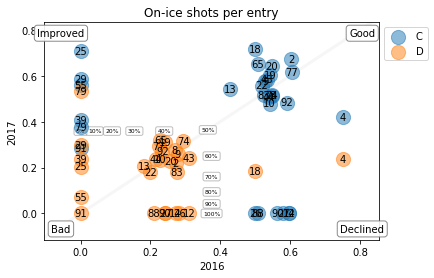

In [40]:
tmp = spe[spe['Entry type'] != 'X'] \
    .drop('Opp', axis=1) \
    .pivot_table(index=['Player', 'Entry type'], columns='Season', values='WSH') \
    .fillna(0) \
    .reset_index()
    
for etype in tmp['Entry type'].unique():
    tmp2 = tmp[tmp['Entry type'] == etype]
    scatter(tmp2.loc[:, 2016].values, tmp2.loc[:, 2017].values, label=etype, s=200, alpha=0.5)

for s, p, etype, e1, e2 in tmp.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center') 
    
vhelper.add_good_bad_fast_slow(bottomleft='Bad', topleft='Improved', topright='Good', bottomright='Declined')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

title('On-ice shots per entry')
xlabel('2016')
ylabel('2017')
legend(loc=2, bbox_to_anchor=(1, 1))

/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:578: RuntimeWarning: divide by zero encountered in true_divide
  return cf/cfpct - cf
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:679: RuntimeWarning: invalid value encountered in subtract
  b = y1 - m*x1
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:614: RuntimeWarning: divide by zero encountered in true_divide
  bottomx = bottomy / slopes
/Users/muneebalam/PycharmProjects/scrapenhl2/scrapenhl2/plot/visualization_helper.py:615: RuntimeWarning: divide by zero encountered in true_divide
  topx = topy / slopes


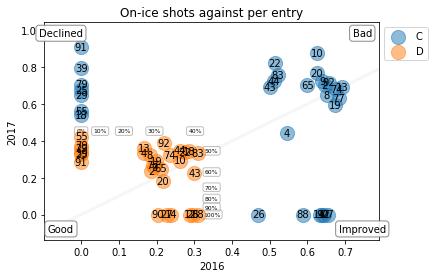

In [41]:
tmp = spe[spe['Entry type'] != 'X'] \
    .drop('WSH', axis=1) \
    .pivot_table(index=['Player', 'Entry type'], columns='Season', values='Opp') \
    .fillna(0) \
    .reset_index()
    
for etype in tmp['Entry type'].unique():
    tmp2 = tmp[tmp['Entry type'] == etype]
    scatter(tmp2.loc[:, 2016].values, tmp2.loc[:, 2017].values, label=etype, s=200, alpha=0.5)

for s, p, etype, e1, e2 in tmp.itertuples():
    annotate(p[:-3], xy=(e1, e2), ha='center', va='center') 
    
vhelper.add_good_bad_fast_slow(bottomleft='Good', topleft='Declined', topright='Bad', bottomright='Improved')
vhelper.add_cfpct_ref_lines_to_plot(ax=gca(), refs=[50])

title('On-ice shots against per entry')
xlabel('2016')
ylabel('2017')
legend(loc=2, bbox_to_anchor=(1, 1))

In [42]:
# Individual level, individual

# Count by entry type
spe = entries2[pd.notnull(entries2['Entry by'])]
spe = spe[spe['Entry by'].str.contains('WSH')] \
    [['Season', 'Entry type', 'Team', 'Game', 'Period', 'Time', 'Entry by', 'Fen total']] \
    .drop_duplicates() \
    [['Season', 'Entry type', 'Team', 'Entry by', 'Fen total']] \
    .assign(Count=1) \
    .groupby(['Season', 'Entry type', 'Team', 'Entry by'], as_index=False) \
    .mean() \
    .pivot_table(index=['Season', 'Entry type', 'Entry by'], columns='Team', values='Fen total') \
    .reset_index() \
    .sort_values(['Entry by', 'Season', 'Entry type'])

spe.pivot_table(index=['Entry by', 'Season'], columns='Entry type', values='WSH')

Entry type              C         D         X
Entry by Season                              
10WSH    2016    0.600000  0.161290       NaN
         2017    0.500000  0.304348       NaN
13WSH    2016    1.000000  0.000000       NaN
         2017    0.615385  0.000000       NaN
14WSH    2016    0.575758  0.292683       NaN
18WSH    2016         NaN  0.000000       NaN
         2017    1.000000  0.333333       NaN
19WSH    2016    0.592593  0.325581       NaN
         2017    0.547619  0.214286       NaN
20WSH    2016    0.537037  0.454545       NaN
         2017    0.575758  0.200000       NaN
22WSH    2016    0.250000  0.250000       NaN
         2017    1.000000  0.111111       NaN
25WSH    2016    1.000000       NaN       NaN
         2017    0.500000  0.307692       NaN
26WSH    2016    0.533333  0.282609       NaN
27WSH    2016    0.500000  0.235294       NaN
29WSH    2016         NaN  1.000000       NaN
         2017    0.833333  0.272727       NaN
2WSH     2016    0.733333  0.428571       NaN
         2017    0.833333  0.333333       NaN
39WSH    2017    0.400000  0.130435       NaN
43WSH    2016    0.343750  0.323529       NaN
         2017    0.363636  0.187500       NaN
44WSH    2016    1.250000  0.178571       NaN
         2017    1.000000  0.266667       NaN
4WSH     2016         NaN  0.000000       NaN
         2017         NaN  0.444444       NaN
55WSH    2017    0.500000  0.000000       NaN
65WSH    2016    0.446809  0.190476       NaN
         2017    0.703704  0.181818       NaN
74WSH    2016    0.266667  0.294118       NaN
         2017    0.384615  0.333333       NaN
77WSH    2016    0.629630  0.258065       NaN
         2017    0.466667  0.545455       NaN
79WSH    2017    0.666667  0.600000       NaN
82WSH    2016    0.545455  0.083333       NaN
83WSH    2016    0.521739  0.250000       NaN
         2017    0.473684  0.083333       NaN
88WSH    2016    0.566667  0.269231       NaN
8WSH     2016    0.606061  0.214286  0.000000
         2017    0.500000  0.285714       NaN
90WSH    2016    0.576271  0.194444       NaN
91WSH    2017    0.000000  0.000000       NaN
92WSH    2016    0.541176  0.228571       NaN
         2017    0.539683  0.400000       NaN
93WSH    2017    0.000000       NaN       NaN
9WSH     2016    0.531250  0.219512       NaN
         2017    0.625000  0.161290       NaN
WSH      2016         NaN       NaN  0.510638
         2017         NaN       NaN  0.439024

### Exits per 60

Some of the relevant result codes:

- P for pass
- C for carry
- D for dump
- M for clear
- F for fail

In [43]:
exits = wsh['exits']

# Drop extra team cols
colnames = [x for x in exits.columns if not x.upper() == x or x[:3] == 'WSH']
exits = exits[colnames]

# Flag exits as WSH or Opp
exits.loc[:, 'Team'] = exits['Attempt'].apply(lambda x: 'WSH' if str(x)[-3:] == 'WSH' else 'Opp')

# Melt to long
idvars = [x for x in exits.columns if x not in ['WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']]
exits2 = exits.melt(id_vars=idvars, value_name='Player').sort_values(['Season', 'Game', '_Secs', 'variable'])

exits2.head()

/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/muneebalam/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Period,Time,Attempt,Result,Pressured?,Pass Target,Entry?,Direction,Game,Season,Time2,_Secs,Team,variable,Player
2406,1,19:55:00,8PIT,I,N,13PIT,NaN,L,20007,2016,19:55,6,Opp,WSH1,2WSH
9068,1,19:55:00,8PIT,I,N,13PIT,NaN,L,20007,2016,19:55,6,Opp,WSH2,27WSH
15730,1,19:55:00,8PIT,I,N,13PIT,NaN,L,20007,2016,19:55,6,Opp,WSH3,92WSH
22392,1,19:55:00,8PIT,I,N,13PIT,NaN,L,20007,2016,19:55,6,Opp,WSH4,8WSH
29054,1,19:55:00,8PIT,I,N,13PIT,NaN,L,20007,2016,19:55,6,Opp,WSH5,77WSH


In [44]:
# Season level

# Count by exit type
exits60 = exits2[['Season', 'Result', 'Team', 'Game', 'Period', 'Time']] \
    .drop_duplicates() \
    [['Season', 'Result', 'Team']] \
    .assign(Count=1) \
    .groupby(['Season', 'Result', 'Team'], as_index=False) \
    .count() \
    .pivot_table(index=['Season', 'Result'], columns='Team', values='Count') \
    .reset_index() \
    .sort_values(['Result', 'Season'])

# Add TOI
toi = dfs['toi']['WSH'] \
    [['Season']].assign(TOI=1) \
    .groupby('Season', as_index=False).count()

exits60 = exits60.merge(toi, how='left', on='Season')
exits60.loc[:, 'WSH60'] = exits60.WSH / (exits60.TOI / 3600)
exits60.loc[:, 'Opp60'] = exits60.Opp / (exits60.TOI / 3600)

exits60

,Season,Result,Opp,WSH,TOI,WSH60,Opp60
0,2016,C,369.0,344.0,60976,20.309630,21.785621
1,2017,C,171.0,207.0,37848,19.689283,16.265060
2,2016,C,1.0,NaN,60976,NaN,0.059040
3,2017,C8,NaN,1.0,37848,0.095117,NaN
4,2016,CD,NaN,1.0,60976,0.059040,NaN
5,2016,D,168.0,157.0,60976,9.269221,9.918657
6,2017,D,115.0,111.0,37848,10.558022,10.938491
7,2016,F,402.0,362.0,60976,21.372343,23.733928
8,2017,F,199.0,222.0,37848,21.116043,18.928345
9,2016,I,67.0,34.0,60976,2.007347,3.955655


In [45]:
# Individual level, on-ice

# Count by exit type
exits60 = exits2[['Season', 'Result', 'Team', 'Game', 'Period', 'Time', 'Player']] \
    [['Season', 'Result', 'Team', 'Player']] \
    .assign(Count=1) \
    .groupby(['Season', 'Result', 'Team', 'Player'], as_index=False) \
    .count() \
    .pivot_table(index=['Season', 'Result', 'Player'], columns='Team', values='Count') \
    .reset_index() \
    .sort_values(['Result', 'Season', 'Player'])

# Add TOI
toi = dfs['toi']['WSH'] \
    [['Season', 'WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']] \
    .melt(id_vars='Season', value_name='Player') \
    .drop('variable', axis=1) \
    .assign(TOI=1) \
    .groupby(['Season', 'Player'], as_index=False).count()
toi.loc[:, 'Player'] = toi['Player'].apply(lambda x: str(wsh_players[x]) + 'WSH' if x in wsh_players else x)

exits60 = exits60.merge(toi, how='left', on=['Season', 'Player'])
exits60.loc[:, 'WSH60'] = exits60.WSH / (exits60.TOI / 3600)
exits60.loc[:, 'Opp60'] = exits60.Opp / (exits60.TOI / 3600)

exits60

,Season,Result,Player,Opp,WSH,TOI,WSH60,Opp60
0,2016,C,10WSH,70.0,72.0,10314,25.130890,24.432810
1,2016,C,12WSH,40.0,40.0,5321,27.062582,27.062582
2,2016,C,13WSH,12.0,11.0,1433,27.634334,30.146546
3,2016,C,14WSH,88.0,80.0,14716,19.570535,21.527589
4,2016,C,18WSH,1.0,4.0,466,30.901288,7.725322
5,2016,C,19WSH,85.0,96.0,17399,19.863211,17.587218
6,2016,C,20WSH,103.0,107.0,15087,25.531915,24.577451
7,2016,C,22WSH,17.0,17.0,2676,22.869955,22.869955
8,2016,C,26WSH,72.0,64.0,11752,19.605174,22.055820
9,2016,C,27WSH,124.0,110.0,20882,18.963701,21.377263


In [46]:
# Individual level, individual

# Count by exit type
exits60 = exits2[exits2.Attempt.str.contains('WSH')] \
    .query('Game == 20502') \
    [['Season', 'Result', 'Team', 'Game', 'Period', 'Time', 'Attempt']] \
    .drop_duplicates() \
    [['Season', 'Result', 'Team', 'Attempt']] \
    .assign(Count=1) \
    .groupby(['Season', 'Result', 'Team', 'Attempt'], as_index=False) \
    .count() \
    .pivot_table(index=['Season', 'Result', 'Attempt'], columns='Team', values='Count') \
    .reset_index() \
    .sort_values(['Result', 'Season', 'Attempt'])

# Add TOI
toi = dfs['toi']['WSH'] \
    [['Season', 'WSH1', 'WSH2', 'WSH3', 'WSH4', 'WSH5']] \
    .melt(id_vars='Season', value_name='Attempt') \
    .drop('variable', axis=1) \
    .assign(TOI=1) \
    .groupby(['Season', 'Attempt'], as_index=False).count()
toi.loc[:, 'Attempt'] = toi['Attempt'].apply(lambda x: str(wsh_players[x]) + 'WSH' if x in wsh_players else x)

exits60 = exits60.merge(toi, how='left', on=['Season', 'Attempt'])
exits60.loc[:, 'WSH60'] = exits60.WSH / (exits60.TOI / 3600)

exits60.pivot_table(index=['Attempt', 'Season'], columns='Result', values='WSH60')

,Result,C,D,F,M,P
Attempt,Season,,,,,
10WSH,2017,0.522193,NaN,NaN,NaN,NaN
13WSH,2017,0.343905,NaN,NaN,0.343905,NaN
19WSH,2017,0.316901,NaN,NaN,0.633803,1.267606
20WSH,2017,0.446041,NaN,0.892083,NaN,0.892083
22WSH,2017,NaN,NaN,0.913938,0.456969,0.913938
25WSH,2017,0.451411,NaN,NaN,0.902821,NaN
29WSH,2017,0.409836,NaN,0.409836,0.409836,NaN
2WSH,2017,0.719065,0.359533,0.719065,0.719065,2.157196
39WSH,2017,0.543478,NaN,0.543478,0.543478,NaN
